In [1]:
%load_ext autoreload
%autoreload 2

Loading data from experiment_results_target_depth_20250309_170751_updated.csv...
Loaded 190 experiment results.
Circuit depths: [8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 19, 21, 23, 25, 27, 29, 31, 33, 35, 37, 39, 41, 43]
Payload sizes: [1, 2, 3, 4, 5]

Training the log-transformed model (Model 2)...
Model 2: Log-transformed target
                            OLS Regression Results                            
Dep. Variable:           success_rate   R-squared:                       0.812
Model:                            OLS   Adj. R-squared:                  0.809
Method:                 Least Squares   F-statistic:                     268.4
Date:                Sun, 09 Mar 2025   Prob (F-statistic):           2.59e-67
Time:                        18:06:19   Log-Likelihood:                -122.55
No. Observations:                 190   AIC:                             253.1
Df Residuals:                     186   BIC:                             266.1
Df Model:                           3

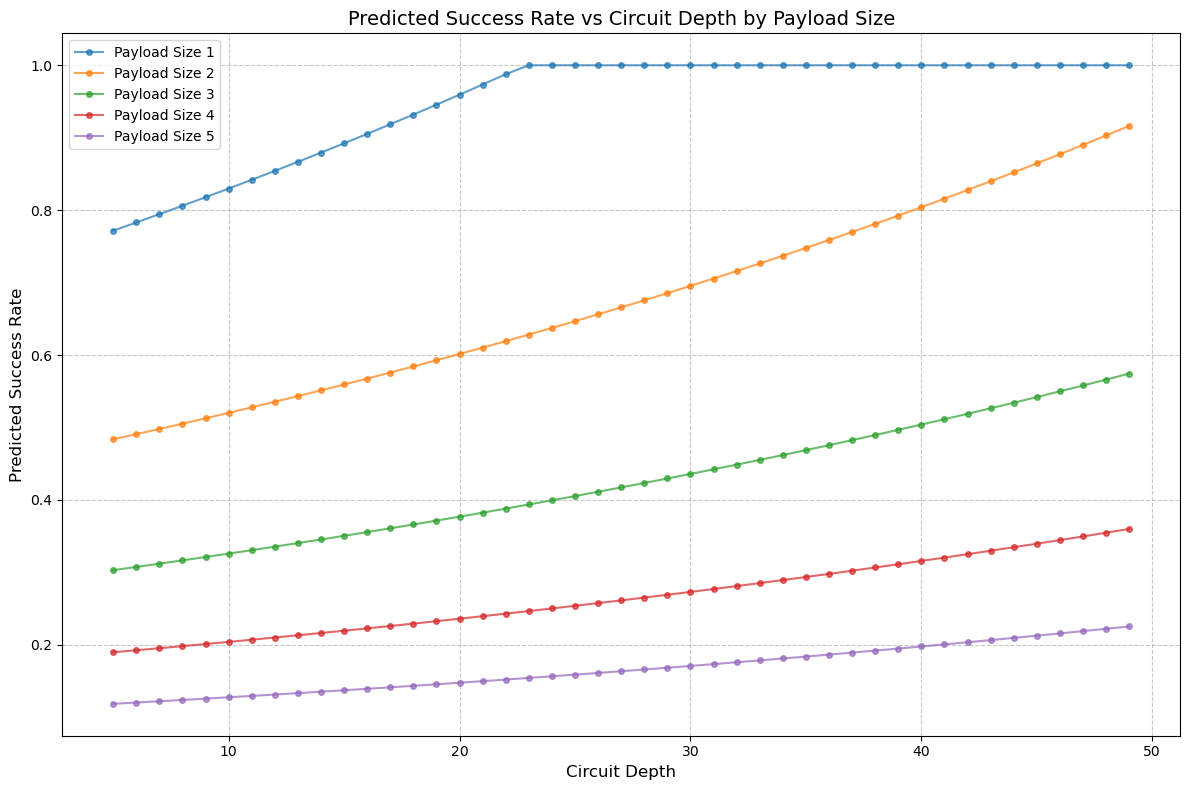

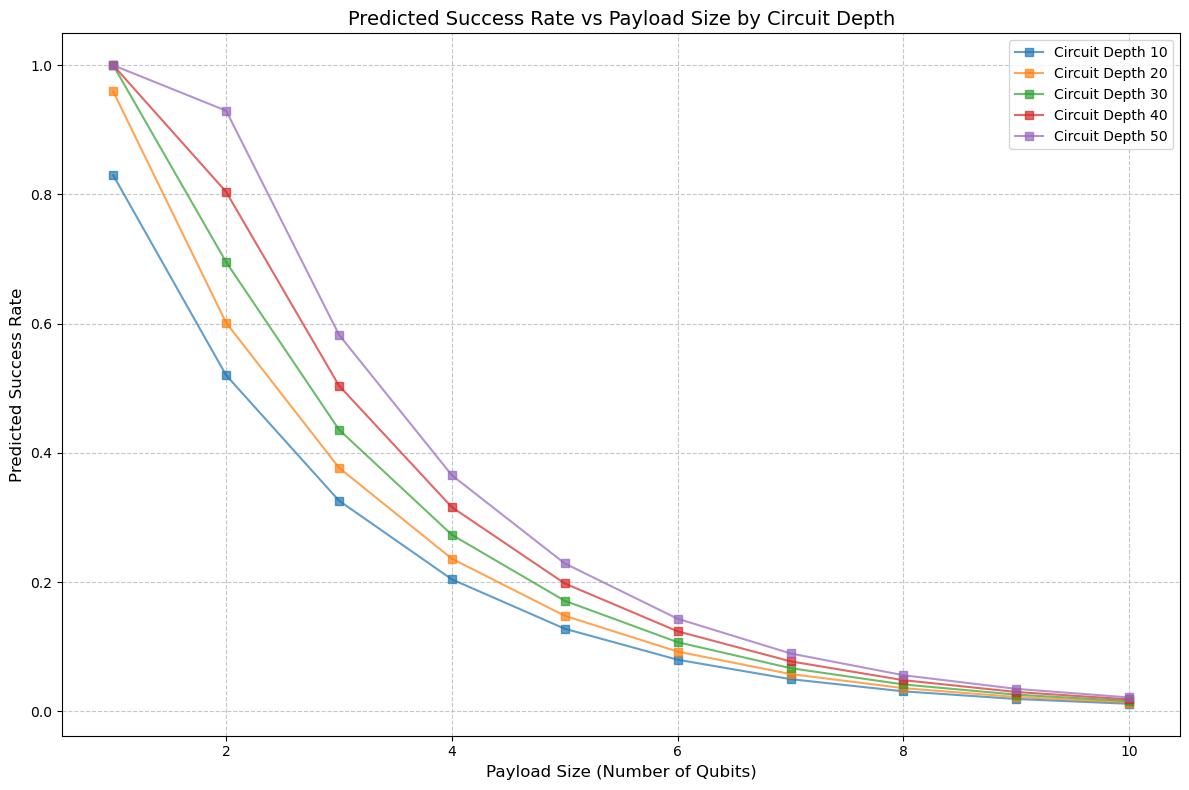

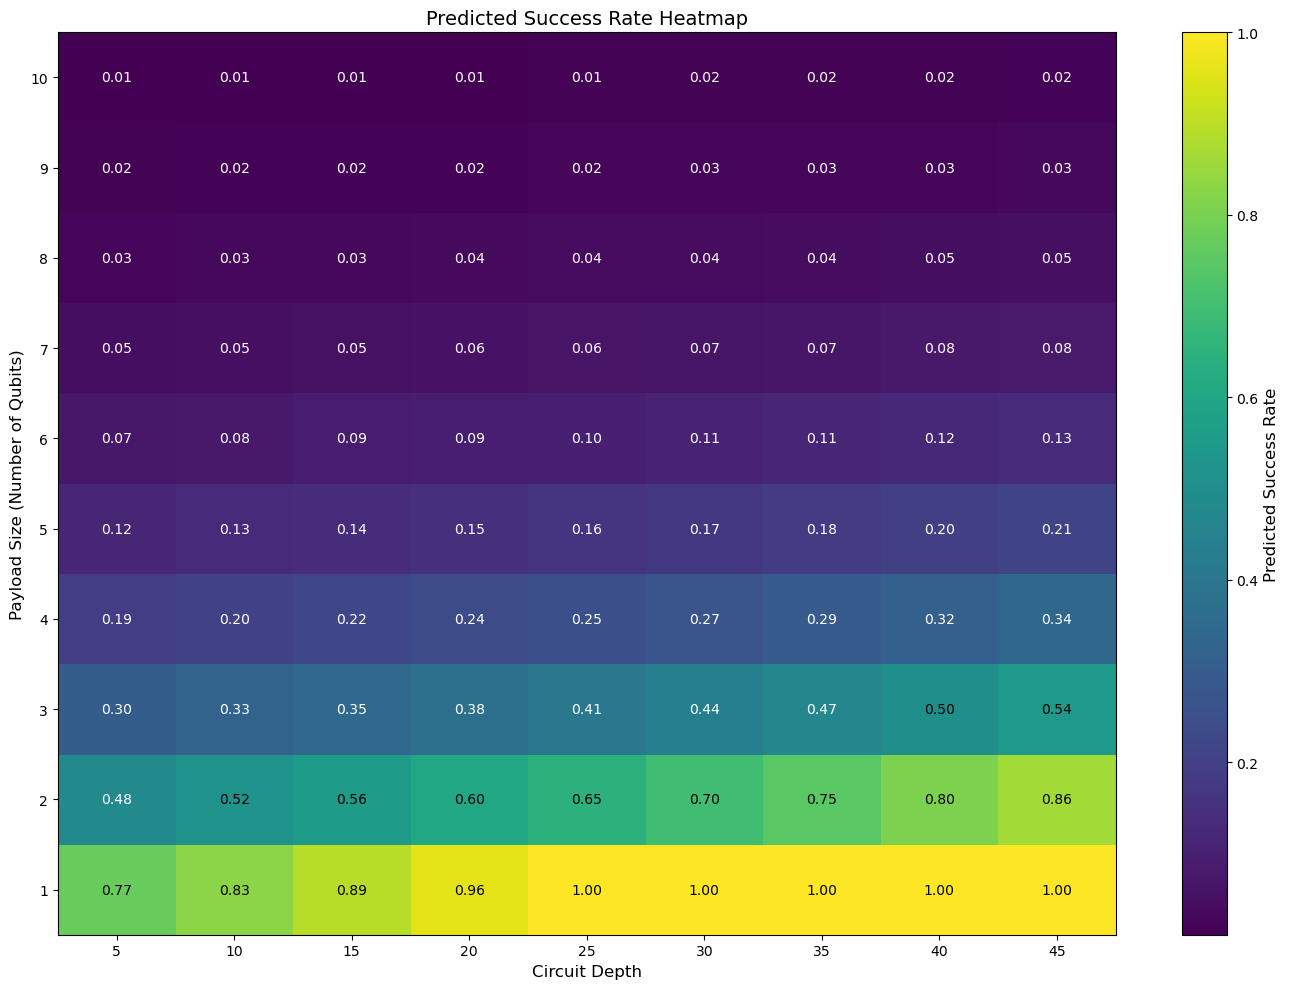


Example predictions:
Circuit with depth=10, size=5, width=2, payload_size=1: Predicted success rate = 0.8298
Circuit with depth=20, size=15, width=4, payload_size=3: Predicted success rate = 0.3770
Circuit with depth=40, size=50, width=11, payload_size=10: Predicted success rate = 0.0183


interactive(children=(IntSlider(value=20, description='Circuit Depth:', max=50, min=5), IntSlider(value=20, de…


Done! Model and prediction plots saved to the circuit_depth_analysis folder.
Use the interactive widget above to make predictions for different circuit parameters.


In [4]:
# Target Depth Model Notebook
# Copy this code into a Jupyter notebook to train, save, and use the best regression model

import os
import sys
import numpy as np
import pandas as pd
import pickle
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns

# Add the results directory to the path if needed
sys.path.append('results')

# Output directory for saved model and plots
OUTPUT_DIR = "circuit_depth_analysis"
os.makedirs(OUTPUT_DIR, exist_ok=True)

# Import the create_experiment_dataframe function
from results.target_depth_analysis import create_experiment_dataframe

# Path to the CSV file
csv_file_path = "experiment_results_target_depth_20250309_170751_updated.csv"

# Load and preprocess the data
print(f"Loading data from {csv_file_path}...")
df = create_experiment_dataframe(csv_file_path)

print(f"Loaded {len(df)} experiment results.")
print(f"Circuit depths: {sorted(df['circuit_depth'].unique())}")
print(f"Payload sizes: {sorted(df['payload_size'].unique())}")

# Function to train the log-transformed model (Model 2)
def train_log_transformed_model(df):
    """
    Train the log-transformed model (Model 2) which was identified as the best model
    """
    # Prepare target variable (log-transformed)
    y = np.log(df['success_rate'] + 0.001)
    
    # Prepare features
    X = df[['circuit_depth', 'circuit_size', 'circuit_width', 'payload_size']]
    X = sm.add_constant(X)
    
    # Train model
    model = sm.OLS(y, X).fit()
    
    print("Model 2: Log-transformed target")
    print(model.summary())
    
    return model

# Train the model
print("\nTraining the log-transformed model (Model 2)...")
model = train_log_transformed_model(df)

# Function to save the model
def save_model(model, filename="target_depth_model.pkl"):
    """
    Save the trained model to a pickle file
    """
    filepath = os.path.join(OUTPUT_DIR, filename)
    with open(filepath, 'wb') as f:
        pickle.dump(model, f)
    
    print(f"Model saved to {filepath}")
    
    # Also save the model equation to a text file
    equation_file = os.path.join(OUTPUT_DIR, "target_depth_model_equation.txt")
    with open(equation_file, 'w') as f:
        f.write("# Target Depth Best Model (Log-transformed)\n\n")
        
        # Get the equation
        equation = "log(success_rate + 0.001) = "
        for i, var in enumerate(model.params.index):
            coef = model.params.iloc[i]  # Use .iloc instead of [] for positional indexing
            if var == 'const':
                equation += f"{coef:.6f}"
            else:
                if coef >= 0:
                    equation += f" + {coef:.6f} * {var}"
                else:
                    equation += f" - {abs(coef):.6f} * {var}"
        
        f.write(equation + "\n\n")
        f.write("To get success_rate: success_rate = exp(prediction) - 0.001\n\n")
        
        # Add model statistics
        f.write(f"R-squared: {model.rsquared:.4f}\n")
        f.write(f"Adjusted R-squared: {model.rsquared_adj:.4f}\n")
        f.write(f"AIC: {model.aic:.4f}\n")
        f.write(f"BIC: {model.bic:.4f}\n\n")
    
    print(f"Model equation saved to {equation_file}")

# Save the model
save_model(model)

# Function to load a saved model
def load_model(filename="target_depth_model.pkl"):
    """
    Load a saved model from a pickle file
    """
    filepath = os.path.join(OUTPUT_DIR, filename)
    with open(filepath, 'rb') as f:
        model = pickle.load(f)
    
    return model

# Function to predict success rate
def predict_success_rate(model, circuit_depth, circuit_size, circuit_width, payload_size):
    """
    Predict success rate for a circuit with given parameters
    """
    # Create a simple DataFrame with our input features
    X = pd.DataFrame({
        'circuit_depth': [circuit_depth],
        'circuit_size': [circuit_size],
        'circuit_width': [circuit_width],
        'payload_size': [payload_size]
    })
    
    # Add the constant term (always has value 1)
    X['const'] = 1.0
    
    # Get the model parameter names (the exact column names it expects)
    model_params = model.params.index.tolist()
    
    try:
        # Reorder columns to match model parameters (if possible)
        X = X[model_params]
    except KeyError:
        # If we can't reorder exactly, create a new DataFrame with the right columns
        new_X = pd.DataFrame(index=[0])
        for param in model_params:
            if param == 'const':
                new_X[param] = 1.0
            elif param in X.columns:
                new_X[param] = X[param].values[0]
            else:
                print(f"Warning: Parameter '{param}' expected by model but not found in input data")
                new_X[param] = 0.0
        X = new_X
    
    # Make prediction (log-transformed)
    log_pred = model.predict(X)[0]
    
    # Transform back to original scale
    success_rate = np.exp(log_pred) - 0.001
    
    # Clip to valid range [0, 1]
    success_rate = np.clip(success_rate, 0, 1)
    
    return success_rate

# Function to generate prediction plots
def generate_prediction_plots(model):
    """
    Generate plots showing predicted success rates for different circuit parameters
    """
    # Plot 1: Success rate vs circuit depth for different payload sizes
    plt.figure(figsize=(12, 8))
    
    # Define range of circuit depths to plot
    depths = np.arange(5, 50, 1)
    
    # For each payload size
    for payload_size in range(1, 6):
        # Assume some reasonable values for other parameters based on payload size
        circuit_width = payload_size + 1  # Width is typically payload_size + 1
        circuit_size = payload_size * 5   # Size scales with payload size
        
        # Calculate predictions
        success_rates = [predict_success_rate(model, depth, circuit_size, circuit_width, payload_size) 
                         for depth in depths]
        
        # Plot
        plt.plot(depths, success_rates, label=f'Payload Size {payload_size}', 
                 marker='o', markersize=4, alpha=0.7)
    
    plt.xlabel('Circuit Depth', fontsize=12)
    plt.ylabel('Predicted Success Rate', fontsize=12)
    plt.title('Predicted Success Rate vs Circuit Depth by Payload Size', fontsize=14)
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.legend()
    plt.tight_layout()
    
    # Save figure
    plt.savefig(os.path.join(OUTPUT_DIR, 'predicted_success_rate_vs_depth.png'), dpi=300, bbox_inches='tight')
    
    # Display in notebook
    plt.show()
    
    # Plot 2: Success rate vs payload size for different circuit depths
    plt.figure(figsize=(12, 8))
    
    # Define range of payload sizes to plot
    payload_sizes = np.arange(1, 11, 1)
    
    # For selected circuit depths
    for depth in [10, 20, 30, 40, 50]:
        # Calculate predictions
        success_rates = []
        for payload_size in payload_sizes:
            # Assume some reasonable values for other parameters based on payload size
            circuit_width = payload_size + 1
            circuit_size = payload_size * 5
            
            success_rates.append(predict_success_rate(model, depth, circuit_size, circuit_width, payload_size))
        
        # Plot
        plt.plot(payload_sizes, success_rates, label=f'Circuit Depth {depth}', 
                 marker='s', markersize=6, alpha=0.7)
    
    plt.xlabel('Payload Size (Number of Qubits)', fontsize=12)
    plt.ylabel('Predicted Success Rate', fontsize=12)
    plt.title('Predicted Success Rate vs Payload Size by Circuit Depth', fontsize=14)
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.legend()
    plt.tight_layout()
    
    # Save figure
    plt.savefig(os.path.join(OUTPUT_DIR, 'predicted_success_rate_vs_payload.png'), dpi=300, bbox_inches='tight')
    
    # Display in notebook
    plt.show()
    
    # Plot 3: Heatmap of predicted success rates
    plt.figure(figsize=(14, 10))
    
    # Create meshgrid for circuit depth and payload size
    depths = np.arange(5, 50, 5)
    payload_sizes = np.arange(1, 11, 1)
    
    # Calculate predictions for each combination
    success_matrix = np.zeros((len(payload_sizes), len(depths)))
    
    for i, payload_size in enumerate(payload_sizes):
        for j, depth in enumerate(depths):
            # Assume some reasonable values for other parameters based on payload size
            circuit_width = payload_size + 1
            circuit_size = payload_size * 5
            
            success_matrix[i, j] = predict_success_rate(model, depth, circuit_size, circuit_width, payload_size)
    
    # Create heatmap
    plt.imshow(success_matrix, cmap='viridis', aspect='auto', origin='lower')
    
    # Add colorbar
    cbar = plt.colorbar()
    cbar.set_label('Predicted Success Rate', fontsize=12)
    
    # Set ticks and labels
    plt.xticks(np.arange(len(depths)), depths)
    plt.yticks(np.arange(len(payload_sizes)), payload_sizes)
    
    plt.xlabel('Circuit Depth', fontsize=12)
    plt.ylabel('Payload Size (Number of Qubits)', fontsize=12)
    plt.title('Predicted Success Rate Heatmap', fontsize=14)
    
    # Add text annotations with success rates
    for i in range(len(payload_sizes)):
        for j in range(len(depths)):
            plt.text(j, i, f'{success_matrix[i, j]:.2f}', 
                     ha='center', va='center', color='white' if success_matrix[i, j] < 0.5 else 'black')
    
    plt.tight_layout()
    
    # Save figure
    plt.savefig(os.path.join(OUTPUT_DIR, 'predicted_success_rate_heatmap.png'), dpi=300, bbox_inches='tight')
    
    # Display in notebook
    plt.show()

# Generate prediction plots
print("\nGenerating prediction plots...")
generate_prediction_plots(model)

# Example predictions
print("\nExample predictions:")

# Example 1: Small circuit with few qubits
depth1, size1, width1, payload1 = 10, 5, 2, 1
pred1 = predict_success_rate(model, depth1, size1, width1, payload1)
print(f"Circuit with depth={depth1}, size={size1}, width={width1}, payload_size={payload1}: "
      f"Predicted success rate = {pred1:.4f}")

# Example 2: Medium circuit
depth2, size2, width2, payload2 = 20, 15, 4, 3
pred2 = predict_success_rate(model, depth2, size2, width2, payload2)
print(f"Circuit with depth={depth2}, size={size2}, width={width2}, payload_size={payload2}: "
      f"Predicted success rate = {pred2:.4f}")

# Example 3: Large circuit with many qubits
depth3, size3, width3, payload3 = 40, 50, 11, 10
pred3 = predict_success_rate(model, depth3, size3, width3, payload3)
print(f"Circuit with depth={depth3}, size={size3}, width={width3}, payload_size={payload3}: "
      f"Predicted success rate = {pred3:.4f}")

# Interactive prediction tool
from ipywidgets import interact, widgets

@interact(
    circuit_depth=widgets.IntSlider(min=5, max=50, step=1, value=20, description='Circuit Depth:'),
    circuit_size=widgets.IntSlider(min=5, max=100, step=5, value=20, description='Circuit Size:'),
    circuit_width=widgets.IntSlider(min=2, max=20, step=1, value=5, description='Circuit Width:'),
    payload_size=widgets.IntSlider(min=1, max=10, step=1, value=3, description='Payload Size:')
)
def predict_interactive(circuit_depth, circuit_size, circuit_width, payload_size):
    """Interactive prediction function for Jupyter notebook"""
    success_rate = predict_success_rate(model, circuit_depth, circuit_size, circuit_width, payload_size)
    print(f"Predicted Success Rate: {success_rate:.4f}")
    
    # Create a simple visualization
    plt.figure(figsize=(6, 1))
    plt.barh(0, success_rate, color='green', alpha=0.7)
    plt.barh(0, 1-success_rate, left=success_rate, color='red', alpha=0.7)
    plt.xlim(0, 1)
    plt.yticks([])
    plt.xticks([0, 0.25, 0.5, 0.75, 1])
    plt.title(f"Success Rate: {success_rate:.2%}")
    plt.tight_layout()
    plt.show()

print("\nDone! Model and prediction plots saved to the circuit_depth_analysis folder.")
print("Use the interactive widget above to make predictions for different circuit parameters.") 